# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [38]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

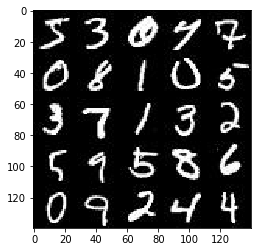

In [39]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

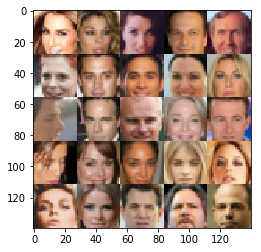

In [40]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [41]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [43]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_input, z_input, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\ProgramData\\Anaconda3\\envs\\tensorflow-gpu\\lib\\runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\ProgramData\\Anaconda3\\envs\\tensorflow-gpu\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\ProgramData\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\ipykernel\\__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "C:\\ProgramData\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\ProgramData\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOL

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [52]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        # First convolutional layer
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer1 = tf.maximum(alpha * layer1, layer1)
    
        # Second convolutional layer
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)

        # Third convolutional Layer
        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)

        flat = tf.reshape(layer3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        output = tf.nn.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [62]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        layer1 = tf.layers.dense(z, 2*2*512)
        layer1 = tf.reshape(layer1, (-1, 2, 2, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)
    
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, 2, 'valid')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
    
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, 2, 'same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
    
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [63]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_real_model, d_real_logits = discriminator(input_real, reuse=False)
    d_fake_model, d_fake_logits = discriminator(g_model, reuse=True)
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_model) * 0.9))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_model)))
    d_loss = d_real_loss + d_fake_loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_model)))
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [69]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [70]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [71]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # optimize
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                
                if steps % 100 == 0:
                    show_generator_output(sess=sess, n_images=10, input_z=input_z, out_channel_dim=image_channels, image_mode=data_image_mode)

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}: ".format(epoch_i + 1, epoch_count),
                         "Discriminator Loss: {:.4f}".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2:  Discriminator Loss: 6.7979 Generator Loss: 0.0028
Epoch 1/2:  Discriminator Loss: 0.6757 Generator Loss: 7.4438
Epoch 1/2:  Discriminator Loss: 3.9661 Generator Loss: 0.0464
Epoch 1/2:  Discriminator Loss: 1.8098 Generator Loss: 2.9059
Epoch 1/2:  Discriminator Loss: 0.6747 Generator Loss: 1.9649
Epoch 1/2:  Discriminator Loss: 0.8211 Generator Loss: 1.8024
Epoch 1/2:  Discriminator Loss: 1.0047 Generator Loss: 2.2429
Epoch 1/2:  Discriminator Loss: 0.8757 Generator Loss: 1.5713
Epoch 1/2:  Discriminator Loss: 0.7345 Generator Loss: 1.4663


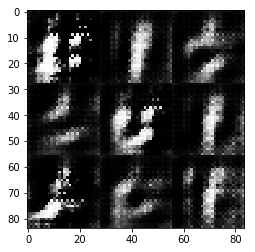

Epoch 1/2:  Discriminator Loss: 0.8958 Generator Loss: 1.1448
Epoch 1/2:  Discriminator Loss: 0.7463 Generator Loss: 1.6159
Epoch 1/2:  Discriminator Loss: 0.7781 Generator Loss: 1.3343
Epoch 1/2:  Discriminator Loss: 1.1262 Generator Loss: 4.1266
Epoch 1/2:  Discriminator Loss: 1.0761 Generator Loss: 2.3440
Epoch 1/2:  Discriminator Loss: 0.6409 Generator Loss: 2.0184
Epoch 1/2:  Discriminator Loss: 1.0603 Generator Loss: 1.8586
Epoch 1/2:  Discriminator Loss: 0.8490 Generator Loss: 1.2882
Epoch 1/2:  Discriminator Loss: 0.6939 Generator Loss: 2.2416
Epoch 1/2:  Discriminator Loss: 0.9608 Generator Loss: 1.1048


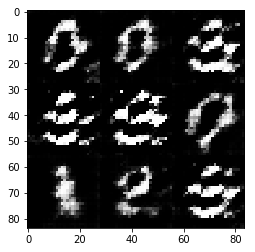

Epoch 1/2:  Discriminator Loss: 0.7405 Generator Loss: 1.6388
Epoch 1/2:  Discriminator Loss: 0.8099 Generator Loss: 1.5353
Epoch 1/2:  Discriminator Loss: 1.0057 Generator Loss: 2.2282
Epoch 1/2:  Discriminator Loss: 1.1383 Generator Loss: 3.5928
Epoch 1/2:  Discriminator Loss: 1.3158 Generator Loss: 0.7358
Epoch 1/2:  Discriminator Loss: 1.2118 Generator Loss: 1.0142
Epoch 1/2:  Discriminator Loss: 0.7871 Generator Loss: 1.9661
Epoch 1/2:  Discriminator Loss: 1.4813 Generator Loss: 0.6323
Epoch 1/2:  Discriminator Loss: 1.1634 Generator Loss: 0.9102
Epoch 1/2:  Discriminator Loss: 1.0374 Generator Loss: 0.9604


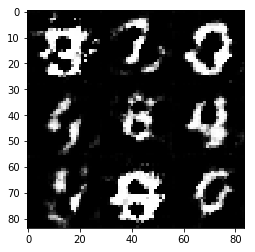

Epoch 1/2:  Discriminator Loss: 0.9602 Generator Loss: 2.2861
Epoch 1/2:  Discriminator Loss: 0.9351 Generator Loss: 1.2228
Epoch 1/2:  Discriminator Loss: 1.9329 Generator Loss: 4.0533
Epoch 1/2:  Discriminator Loss: 0.6800 Generator Loss: 2.2010
Epoch 1/2:  Discriminator Loss: 1.3560 Generator Loss: 0.7032
Epoch 1/2:  Discriminator Loss: 0.9000 Generator Loss: 2.5785
Epoch 1/2:  Discriminator Loss: 0.9000 Generator Loss: 1.2168
Epoch 1/2:  Discriminator Loss: 1.0768 Generator Loss: 1.0777
Epoch 1/2:  Discriminator Loss: 0.8087 Generator Loss: 1.7700
Epoch 1/2:  Discriminator Loss: 1.1497 Generator Loss: 1.0074


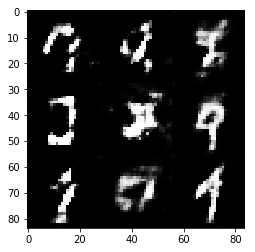

Epoch 1/2:  Discriminator Loss: 1.1395 Generator Loss: 0.8962
Epoch 1/2:  Discriminator Loss: 0.9484 Generator Loss: 1.0350
Epoch 1/2:  Discriminator Loss: 0.9779 Generator Loss: 2.2153
Epoch 1/2:  Discriminator Loss: 1.4882 Generator Loss: 2.8855
Epoch 1/2:  Discriminator Loss: 1.2729 Generator Loss: 1.9985
Epoch 1/2:  Discriminator Loss: 0.8792 Generator Loss: 1.6254
Epoch 1/2:  Discriminator Loss: 1.2207 Generator Loss: 0.8937
Epoch 1/2:  Discriminator Loss: 0.9087 Generator Loss: 1.2117
Epoch 1/2:  Discriminator Loss: 0.7181 Generator Loss: 2.1072
Epoch 1/2:  Discriminator Loss: 1.0843 Generator Loss: 2.1904


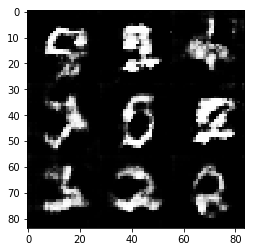

Epoch 1/2:  Discriminator Loss: 0.9440 Generator Loss: 1.5164
Epoch 1/2:  Discriminator Loss: 2.0832 Generator Loss: 4.1526
Epoch 1/2:  Discriminator Loss: 0.9307 Generator Loss: 2.0033
Epoch 1/2:  Discriminator Loss: 1.4049 Generator Loss: 2.5551
Epoch 1/2:  Discriminator Loss: 0.9912 Generator Loss: 1.1645
Epoch 1/2:  Discriminator Loss: 0.8161 Generator Loss: 1.7748
Epoch 1/2:  Discriminator Loss: 1.3219 Generator Loss: 0.8385
Epoch 1/2:  Discriminator Loss: 1.1219 Generator Loss: 0.9141
Epoch 1/2:  Discriminator Loss: 0.9923 Generator Loss: 1.4592
Epoch 1/2:  Discriminator Loss: 1.3831 Generator Loss: 0.5702


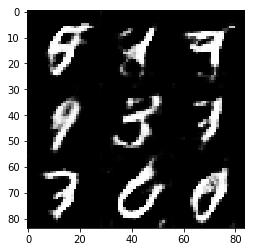

Epoch 1/2:  Discriminator Loss: 1.2922 Generator Loss: 2.7871
Epoch 1/2:  Discriminator Loss: 1.2221 Generator Loss: 1.1522
Epoch 1/2:  Discriminator Loss: 0.9261 Generator Loss: 1.2085
Epoch 1/2:  Discriminator Loss: 0.8680 Generator Loss: 1.1994
Epoch 1/2:  Discriminator Loss: 1.2782 Generator Loss: 0.5930
Epoch 1/2:  Discriminator Loss: 1.3764 Generator Loss: 0.6255
Epoch 1/2:  Discriminator Loss: 1.2496 Generator Loss: 0.7194
Epoch 1/2:  Discriminator Loss: 1.3903 Generator Loss: 0.5252
Epoch 1/2:  Discriminator Loss: 1.0647 Generator Loss: 0.9101
Epoch 1/2:  Discriminator Loss: 0.8871 Generator Loss: 1.8163


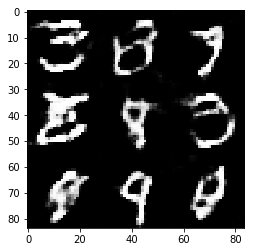

Epoch 1/2:  Discriminator Loss: 1.2583 Generator Loss: 0.6773
Epoch 1/2:  Discriminator Loss: 1.5224 Generator Loss: 2.7448
Epoch 1/2:  Discriminator Loss: 1.1123 Generator Loss: 0.9721
Epoch 1/2:  Discriminator Loss: 0.9988 Generator Loss: 2.0561
Epoch 1/2:  Discriminator Loss: 1.2890 Generator Loss: 2.4162
Epoch 1/2:  Discriminator Loss: 1.1290 Generator Loss: 1.7456
Epoch 1/2:  Discriminator Loss: 0.8980 Generator Loss: 1.2127
Epoch 1/2:  Discriminator Loss: 1.0031 Generator Loss: 0.9105
Epoch 1/2:  Discriminator Loss: 1.6219 Generator Loss: 2.8294
Epoch 1/2:  Discriminator Loss: 0.9285 Generator Loss: 1.2836


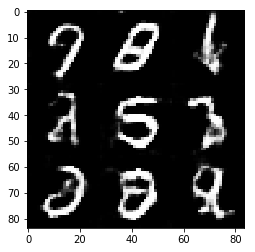

Epoch 1/2:  Discriminator Loss: 1.0483 Generator Loss: 0.9432
Epoch 1/2:  Discriminator Loss: 0.9009 Generator Loss: 1.3856
Epoch 1/2:  Discriminator Loss: 1.0508 Generator Loss: 0.9387
Epoch 1/2:  Discriminator Loss: 0.8013 Generator Loss: 1.5851
Epoch 1/2:  Discriminator Loss: 1.5571 Generator Loss: 0.5675
Epoch 1/2:  Discriminator Loss: 1.1175 Generator Loss: 0.8867
Epoch 1/2:  Discriminator Loss: 1.7015 Generator Loss: 0.6224
Epoch 1/2:  Discriminator Loss: 1.5092 Generator Loss: 0.5220
Epoch 1/2:  Discriminator Loss: 0.8472 Generator Loss: 1.3993
Epoch 1/2:  Discriminator Loss: 1.1232 Generator Loss: 0.7377


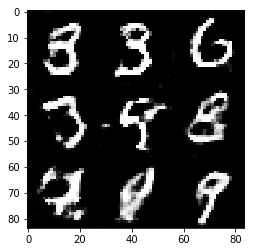

Epoch 1/2:  Discriminator Loss: 1.0037 Generator Loss: 1.7110
Epoch 1/2:  Discriminator Loss: 1.1232 Generator Loss: 0.9886
Epoch 1/2:  Discriminator Loss: 1.0471 Generator Loss: 1.6842
Epoch 1/2:  Discriminator Loss: 1.0983 Generator Loss: 0.7989
Epoch 2/2:  Discriminator Loss: 1.5558 Generator Loss: 0.5262
Epoch 2/2:  Discriminator Loss: 0.9979 Generator Loss: 1.7809
Epoch 2/2:  Discriminator Loss: 1.0847 Generator Loss: 0.9386
Epoch 2/2:  Discriminator Loss: 1.3092 Generator Loss: 0.5860
Epoch 2/2:  Discriminator Loss: 1.5057 Generator Loss: 1.9967
Epoch 2/2:  Discriminator Loss: 1.2076 Generator Loss: 2.2485


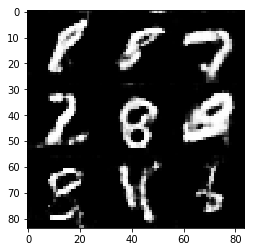

Epoch 2/2:  Discriminator Loss: 0.9631 Generator Loss: 1.2780
Epoch 2/2:  Discriminator Loss: 1.2291 Generator Loss: 0.7937
Epoch 2/2:  Discriminator Loss: 0.8998 Generator Loss: 1.3383
Epoch 2/2:  Discriminator Loss: 0.8067 Generator Loss: 1.4104
Epoch 2/2:  Discriminator Loss: 1.3170 Generator Loss: 0.6422
Epoch 2/2:  Discriminator Loss: 1.0305 Generator Loss: 0.9490
Epoch 2/2:  Discriminator Loss: 1.3386 Generator Loss: 0.5650
Epoch 2/2:  Discriminator Loss: 1.2693 Generator Loss: 0.5870
Epoch 2/2:  Discriminator Loss: 1.3027 Generator Loss: 0.6217
Epoch 2/2:  Discriminator Loss: 1.0437 Generator Loss: 1.8479


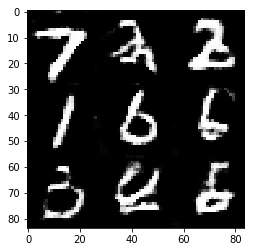

Epoch 2/2:  Discriminator Loss: 0.9576 Generator Loss: 0.9700
Epoch 2/2:  Discriminator Loss: 0.9281 Generator Loss: 1.3998
Epoch 2/2:  Discriminator Loss: 1.0249 Generator Loss: 1.5957
Epoch 2/2:  Discriminator Loss: 0.9035 Generator Loss: 1.5452
Epoch 2/2:  Discriminator Loss: 0.9463 Generator Loss: 1.0741
Epoch 2/2:  Discriminator Loss: 1.1100 Generator Loss: 0.8603
Epoch 2/2:  Discriminator Loss: 1.4143 Generator Loss: 0.5555
Epoch 2/2:  Discriminator Loss: 1.1067 Generator Loss: 0.9521
Epoch 2/2:  Discriminator Loss: 2.0548 Generator Loss: 0.2734
Epoch 2/2:  Discriminator Loss: 1.2065 Generator Loss: 0.7218


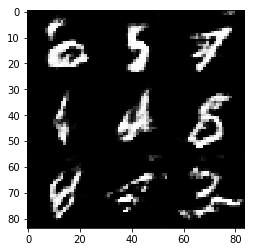

Epoch 2/2:  Discriminator Loss: 1.0674 Generator Loss: 0.8604
Epoch 2/2:  Discriminator Loss: 1.3512 Generator Loss: 0.6131
Epoch 2/2:  Discriminator Loss: 1.0363 Generator Loss: 1.6795
Epoch 2/2:  Discriminator Loss: 1.7969 Generator Loss: 0.3406
Epoch 2/2:  Discriminator Loss: 1.4799 Generator Loss: 0.5197
Epoch 2/2:  Discriminator Loss: 1.0016 Generator Loss: 1.7979
Epoch 2/2:  Discriminator Loss: 0.9177 Generator Loss: 1.8577
Epoch 2/2:  Discriminator Loss: 1.5590 Generator Loss: 0.4559
Epoch 2/2:  Discriminator Loss: 1.5143 Generator Loss: 0.5068
Epoch 2/2:  Discriminator Loss: 1.1916 Generator Loss: 0.7320


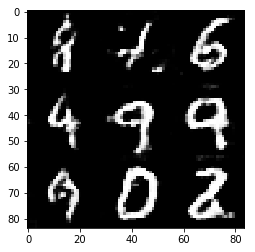

Epoch 2/2:  Discriminator Loss: 0.7472 Generator Loss: 1.4549
Epoch 2/2:  Discriminator Loss: 1.0184 Generator Loss: 0.9084
Epoch 2/2:  Discriminator Loss: 3.5539 Generator Loss: 5.0548
Epoch 2/2:  Discriminator Loss: 1.1165 Generator Loss: 0.8685
Epoch 2/2:  Discriminator Loss: 1.3047 Generator Loss: 0.6811
Epoch 2/2:  Discriminator Loss: 1.0706 Generator Loss: 0.8466
Epoch 2/2:  Discriminator Loss: 1.2135 Generator Loss: 1.8895
Epoch 2/2:  Discriminator Loss: 1.0492 Generator Loss: 1.8537
Epoch 2/2:  Discriminator Loss: 1.0788 Generator Loss: 0.9253
Epoch 2/2:  Discriminator Loss: 0.9129 Generator Loss: 1.0174


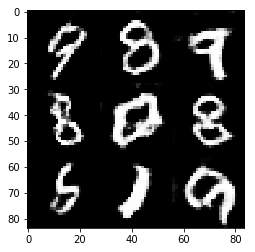

Epoch 2/2:  Discriminator Loss: 0.9083 Generator Loss: 1.2601
Epoch 2/2:  Discriminator Loss: 1.0677 Generator Loss: 0.8976
Epoch 2/2:  Discriminator Loss: 1.0508 Generator Loss: 1.4203
Epoch 2/2:  Discriminator Loss: 1.3019 Generator Loss: 0.5942
Epoch 2/2:  Discriminator Loss: 0.8814 Generator Loss: 1.1347
Epoch 2/2:  Discriminator Loss: 1.5640 Generator Loss: 0.5285
Epoch 2/2:  Discriminator Loss: 1.3735 Generator Loss: 0.6145
Epoch 2/2:  Discriminator Loss: 1.4212 Generator Loss: 0.5140
Epoch 2/2:  Discriminator Loss: 1.0083 Generator Loss: 0.9761
Epoch 2/2:  Discriminator Loss: 1.0890 Generator Loss: 1.0072


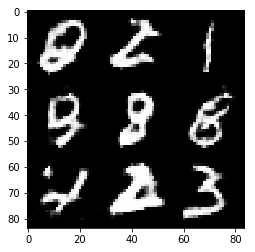

Epoch 2/2:  Discriminator Loss: 1.1824 Generator Loss: 0.8288
Epoch 2/2:  Discriminator Loss: 0.9709 Generator Loss: 1.0146
Epoch 2/2:  Discriminator Loss: 0.7924 Generator Loss: 1.6981
Epoch 2/2:  Discriminator Loss: 0.6478 Generator Loss: 1.7817
Epoch 2/2:  Discriminator Loss: 1.1084 Generator Loss: 0.9802
Epoch 2/2:  Discriminator Loss: 1.2097 Generator Loss: 0.8420
Epoch 2/2:  Discriminator Loss: 0.9581 Generator Loss: 1.7066
Epoch 2/2:  Discriminator Loss: 1.1256 Generator Loss: 0.8932
Epoch 2/2:  Discriminator Loss: 1.0893 Generator Loss: 0.7875
Epoch 2/2:  Discriminator Loss: 1.4234 Generator Loss: 0.5324


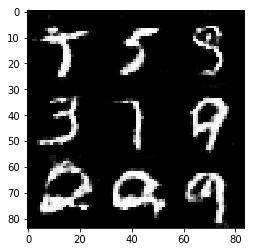

Epoch 2/2:  Discriminator Loss: 1.2854 Generator Loss: 0.6173
Epoch 2/2:  Discriminator Loss: 1.3121 Generator Loss: 0.6572
Epoch 2/2:  Discriminator Loss: 1.0528 Generator Loss: 0.8112
Epoch 2/2:  Discriminator Loss: 1.0583 Generator Loss: 1.0539
Epoch 2/2:  Discriminator Loss: 0.9955 Generator Loss: 0.9493
Epoch 2/2:  Discriminator Loss: 1.1539 Generator Loss: 0.7065
Epoch 2/2:  Discriminator Loss: 1.1572 Generator Loss: 0.8185
Epoch 2/2:  Discriminator Loss: 1.3179 Generator Loss: 0.5970
Epoch 2/2:  Discriminator Loss: 0.7525 Generator Loss: 1.5137
Epoch 2/2:  Discriminator Loss: 1.0655 Generator Loss: 0.8469


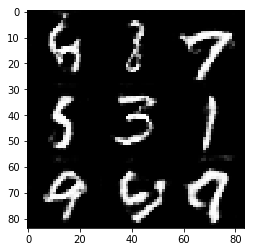

Epoch 2/2:  Discriminator Loss: 1.7996 Generator Loss: 0.3500
Epoch 2/2:  Discriminator Loss: 1.0874 Generator Loss: 1.0018
Epoch 2/2:  Discriminator Loss: 1.2734 Generator Loss: 0.6067
Epoch 2/2:  Discriminator Loss: 1.3964 Generator Loss: 0.6433
Epoch 2/2:  Discriminator Loss: 0.7533 Generator Loss: 1.6156
Epoch 2/2:  Discriminator Loss: 1.4085 Generator Loss: 3.6424
Epoch 2/2:  Discriminator Loss: 0.8800 Generator Loss: 1.1531
Epoch 2/2:  Discriminator Loss: 0.8276 Generator Loss: 1.3360
Epoch 2/2:  Discriminator Loss: 1.3802 Generator Loss: 0.8411
Epoch 2/2:  Discriminator Loss: 1.1663 Generator Loss: 0.9075


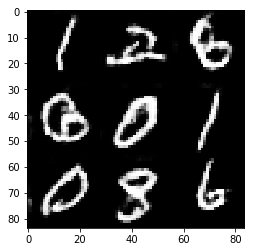

Epoch 2/2:  Discriminator Loss: 1.1503 Generator Loss: 0.8924
Epoch 2/2:  Discriminator Loss: 1.2155 Generator Loss: 1.0359
Epoch 2/2:  Discriminator Loss: 1.1650 Generator Loss: 0.7251
Epoch 2/2:  Discriminator Loss: 1.1542 Generator Loss: 0.7841
Epoch 2/2:  Discriminator Loss: 1.3873 Generator Loss: 0.5712
Epoch 2/2:  Discriminator Loss: 0.9050 Generator Loss: 2.0854
Epoch 2/2:  Discriminator Loss: 1.1245 Generator Loss: 2.1302
Epoch 2/2:  Discriminator Loss: 0.9829 Generator Loss: 0.9913


In [72]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5
tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1:  Discriminator Loss: 0.7395 Generator Loss: 4.4827
Epoch 1/1:  Discriminator Loss: 1.8255 Generator Loss: 0.4568
Epoch 1/1:  Discriminator Loss: 0.9015 Generator Loss: 1.9603
Epoch 1/1:  Discriminator Loss: 1.1377 Generator Loss: 1.0985
Epoch 1/1:  Discriminator Loss: 1.2266 Generator Loss: 0.8819
Epoch 1/1:  Discriminator Loss: 2.6115 Generator Loss: 4.8626
Epoch 1/1:  Discriminator Loss: 0.8415 Generator Loss: 1.5689
Epoch 1/1:  Discriminator Loss: 1.1784 Generator Loss: 1.2221
Epoch 1/1:  Discriminator Loss: 0.7664 Generator Loss: 4.6399


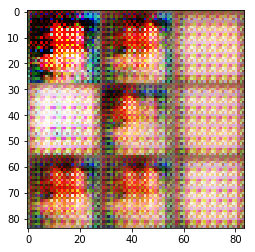

Epoch 1/1:  Discriminator Loss: 0.8451 Generator Loss: 1.1678
Epoch 1/1:  Discriminator Loss: 0.4582 Generator Loss: 3.5397
Epoch 1/1:  Discriminator Loss: 0.6559 Generator Loss: 1.7370
Epoch 1/1:  Discriminator Loss: 0.6800 Generator Loss: 1.6107
Epoch 1/1:  Discriminator Loss: 0.7694 Generator Loss: 1.3444
Epoch 1/1:  Discriminator Loss: 1.1874 Generator Loss: 4.0154
Epoch 1/1:  Discriminator Loss: 0.5342 Generator Loss: 2.0559
Epoch 1/1:  Discriminator Loss: 0.7150 Generator Loss: 1.5557
Epoch 1/1:  Discriminator Loss: 1.4797 Generator Loss: 2.3807
Epoch 1/1:  Discriminator Loss: 0.9484 Generator Loss: 0.9688


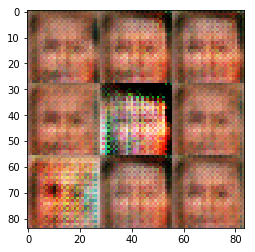

Epoch 1/1:  Discriminator Loss: 2.8310 Generator Loss: 6.5342
Epoch 1/1:  Discriminator Loss: 1.7841 Generator Loss: 0.5851
Epoch 1/1:  Discriminator Loss: 1.0146 Generator Loss: 1.1912
Epoch 1/1:  Discriminator Loss: 0.9662 Generator Loss: 1.5800
Epoch 1/1:  Discriminator Loss: 1.4661 Generator Loss: 0.4738
Epoch 1/1:  Discriminator Loss: 1.2432 Generator Loss: 0.8917
Epoch 1/1:  Discriminator Loss: 0.6535 Generator Loss: 1.6374
Epoch 1/1:  Discriminator Loss: 0.9974 Generator Loss: 1.3541
Epoch 1/1:  Discriminator Loss: 0.8353 Generator Loss: 1.5727
Epoch 1/1:  Discriminator Loss: 0.6469 Generator Loss: 2.2327


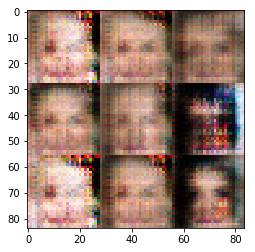

Epoch 1/1:  Discriminator Loss: 1.3770 Generator Loss: 0.8261
Epoch 1/1:  Discriminator Loss: 1.0995 Generator Loss: 1.4652
Epoch 1/1:  Discriminator Loss: 1.0629 Generator Loss: 1.2153
Epoch 1/1:  Discriminator Loss: 0.9000 Generator Loss: 1.2042
Epoch 1/1:  Discriminator Loss: 1.6268 Generator Loss: 0.5902
Epoch 1/1:  Discriminator Loss: 0.9176 Generator Loss: 2.0185
Epoch 1/1:  Discriminator Loss: 1.8447 Generator Loss: 0.3906
Epoch 1/1:  Discriminator Loss: 1.7734 Generator Loss: 0.3535
Epoch 1/1:  Discriminator Loss: 1.5053 Generator Loss: 0.7125
Epoch 1/1:  Discriminator Loss: 1.3047 Generator Loss: 0.6426


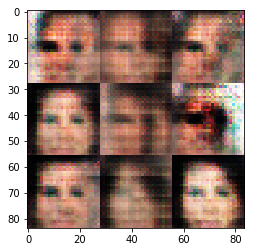

Epoch 1/1:  Discriminator Loss: 1.0009 Generator Loss: 1.0327
Epoch 1/1:  Discriminator Loss: 0.9254 Generator Loss: 1.0114
Epoch 1/1:  Discriminator Loss: 0.8800 Generator Loss: 1.1821
Epoch 1/1:  Discriminator Loss: 1.4903 Generator Loss: 1.7612
Epoch 1/1:  Discriminator Loss: 1.3835 Generator Loss: 0.9259
Epoch 1/1:  Discriminator Loss: 0.9983 Generator Loss: 1.2802
Epoch 1/1:  Discriminator Loss: 1.3034 Generator Loss: 1.3182
Epoch 1/1:  Discriminator Loss: 1.1819 Generator Loss: 1.9588
Epoch 1/1:  Discriminator Loss: 0.7528 Generator Loss: 1.6282
Epoch 1/1:  Discriminator Loss: 2.4861 Generator Loss: 3.5042


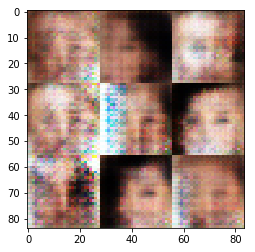

Epoch 1/1:  Discriminator Loss: 3.3295 Generator Loss: 4.0171
Epoch 1/1:  Discriminator Loss: 1.1325 Generator Loss: 1.2057
Epoch 1/1:  Discriminator Loss: 1.1314 Generator Loss: 2.1621
Epoch 1/1:  Discriminator Loss: 0.8454 Generator Loss: 1.3748
Epoch 1/1:  Discriminator Loss: 0.7987 Generator Loss: 1.5668
Epoch 1/1:  Discriminator Loss: 0.6431 Generator Loss: 1.7426
Epoch 1/1:  Discriminator Loss: 1.3254 Generator Loss: 0.7572
Epoch 1/1:  Discriminator Loss: 1.1531 Generator Loss: 0.7705
Epoch 1/1:  Discriminator Loss: 2.5468 Generator Loss: 3.2654
Epoch 1/1:  Discriminator Loss: 1.0649 Generator Loss: 1.7289


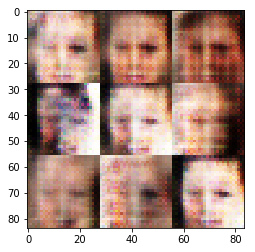

Epoch 1/1:  Discriminator Loss: 1.2739 Generator Loss: 0.7922
Epoch 1/1:  Discriminator Loss: 1.0998 Generator Loss: 1.1094
Epoch 1/1:  Discriminator Loss: 0.9659 Generator Loss: 1.3957
Epoch 1/1:  Discriminator Loss: 0.9572 Generator Loss: 1.7066
Epoch 1/1:  Discriminator Loss: 1.2426 Generator Loss: 2.6653
Epoch 1/1:  Discriminator Loss: 1.0585 Generator Loss: 1.5140
Epoch 1/1:  Discriminator Loss: 0.7812 Generator Loss: 1.3262
Epoch 1/1:  Discriminator Loss: 1.2448 Generator Loss: 0.9957
Epoch 1/1:  Discriminator Loss: 1.1981 Generator Loss: 0.8917
Epoch 1/1:  Discriminator Loss: 1.0324 Generator Loss: 1.1427


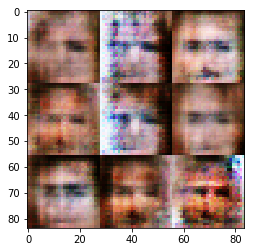

Epoch 1/1:  Discriminator Loss: 0.9432 Generator Loss: 1.2130
Epoch 1/1:  Discriminator Loss: 1.5652 Generator Loss: 2.0942
Epoch 1/1:  Discriminator Loss: 1.1564 Generator Loss: 1.3118
Epoch 1/1:  Discriminator Loss: 0.6519 Generator Loss: 2.0457
Epoch 1/1:  Discriminator Loss: 1.5629 Generator Loss: 0.5551
Epoch 1/1:  Discriminator Loss: 1.2068 Generator Loss: 1.2013
Epoch 1/1:  Discriminator Loss: 1.3906 Generator Loss: 0.7505
Epoch 1/1:  Discriminator Loss: 0.9221 Generator Loss: 1.1143
Epoch 1/1:  Discriminator Loss: 1.4064 Generator Loss: 2.0569
Epoch 1/1:  Discriminator Loss: 1.2771 Generator Loss: 1.1486


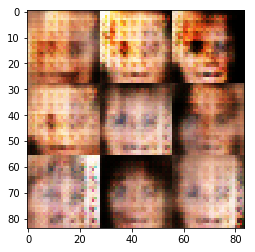

Epoch 1/1:  Discriminator Loss: 1.1541 Generator Loss: 2.4415
Epoch 1/1:  Discriminator Loss: 0.6800 Generator Loss: 2.0569
Epoch 1/1:  Discriminator Loss: 1.4249 Generator Loss: 0.8675
Epoch 1/1:  Discriminator Loss: 1.2764 Generator Loss: 1.0710
Epoch 1/1:  Discriminator Loss: 1.0660 Generator Loss: 1.1014
Epoch 1/1:  Discriminator Loss: 0.7259 Generator Loss: 1.6170
Epoch 1/1:  Discriminator Loss: 1.1051 Generator Loss: 1.6676
Epoch 1/1:  Discriminator Loss: 1.1354 Generator Loss: 1.7980
Epoch 1/1:  Discriminator Loss: 0.6761 Generator Loss: 1.6334
Epoch 1/1:  Discriminator Loss: 1.5156 Generator Loss: 1.5647


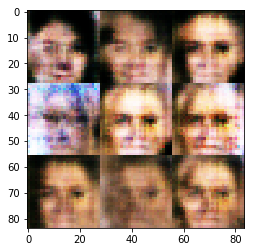

Epoch 1/1:  Discriminator Loss: 1.1581 Generator Loss: 0.8400
Epoch 1/1:  Discriminator Loss: 1.2319 Generator Loss: 0.9155
Epoch 1/1:  Discriminator Loss: 1.1259 Generator Loss: 1.2722
Epoch 1/1:  Discriminator Loss: 1.1100 Generator Loss: 0.9862
Epoch 1/1:  Discriminator Loss: 1.4203 Generator Loss: 0.6245
Epoch 1/1:  Discriminator Loss: 1.0789 Generator Loss: 1.0954
Epoch 1/1:  Discriminator Loss: 1.0123 Generator Loss: 0.8743
Epoch 1/1:  Discriminator Loss: 2.2175 Generator Loss: 3.6379
Epoch 1/1:  Discriminator Loss: 1.2278 Generator Loss: 0.9347
Epoch 1/1:  Discriminator Loss: 1.2888 Generator Loss: 2.0826


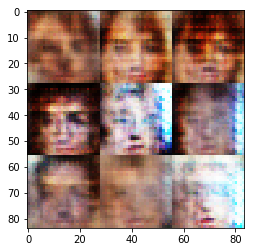

Epoch 1/1:  Discriminator Loss: 0.6490 Generator Loss: 1.8152
Epoch 1/1:  Discriminator Loss: 1.0649 Generator Loss: 2.1660
Epoch 1/1:  Discriminator Loss: 0.9028 Generator Loss: 1.1449
Epoch 1/1:  Discriminator Loss: 0.8530 Generator Loss: 1.3710
Epoch 1/1:  Discriminator Loss: 1.0290 Generator Loss: 0.9389
Epoch 1/1:  Discriminator Loss: 0.8654 Generator Loss: 1.6582
Epoch 1/1:  Discriminator Loss: 1.2254 Generator Loss: 1.6656
Epoch 1/1:  Discriminator Loss: 1.3104 Generator Loss: 1.0881
Epoch 1/1:  Discriminator Loss: 0.9066 Generator Loss: 1.1216
Epoch 1/1:  Discriminator Loss: 1.2036 Generator Loss: 1.8936


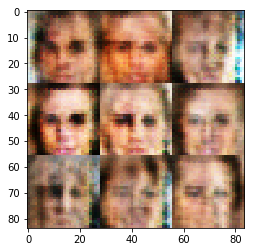

Epoch 1/1:  Discriminator Loss: 1.2411 Generator Loss: 0.7633
Epoch 1/1:  Discriminator Loss: 1.8149 Generator Loss: 0.3240
Epoch 1/1:  Discriminator Loss: 1.0935 Generator Loss: 1.0569
Epoch 1/1:  Discriminator Loss: 1.2325 Generator Loss: 0.9316
Epoch 1/1:  Discriminator Loss: 0.9497 Generator Loss: 1.5093
Epoch 1/1:  Discriminator Loss: 1.0765 Generator Loss: 1.5373
Epoch 1/1:  Discriminator Loss: 1.5713 Generator Loss: 0.4923
Epoch 1/1:  Discriminator Loss: 1.1140 Generator Loss: 0.9273
Epoch 1/1:  Discriminator Loss: 1.2120 Generator Loss: 0.7422
Epoch 1/1:  Discriminator Loss: 0.9428 Generator Loss: 1.1911


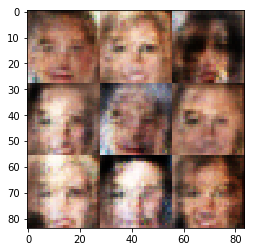

Epoch 1/1:  Discriminator Loss: 1.5388 Generator Loss: 0.4557
Epoch 1/1:  Discriminator Loss: 1.2250 Generator Loss: 0.7392
Epoch 1/1:  Discriminator Loss: 1.3844 Generator Loss: 1.3394
Epoch 1/1:  Discriminator Loss: 1.0833 Generator Loss: 1.2611
Epoch 1/1:  Discriminator Loss: 0.9858 Generator Loss: 1.3644
Epoch 1/1:  Discriminator Loss: 1.0707 Generator Loss: 1.5523
Epoch 1/1:  Discriminator Loss: 1.1359 Generator Loss: 1.1931
Epoch 1/1:  Discriminator Loss: 1.4542 Generator Loss: 0.4968
Epoch 1/1:  Discriminator Loss: 1.5401 Generator Loss: 0.4504
Epoch 1/1:  Discriminator Loss: 1.3136 Generator Loss: 0.6586


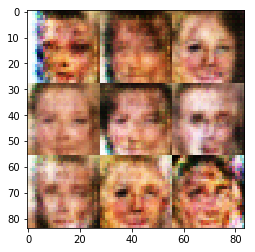

Epoch 1/1:  Discriminator Loss: 2.1283 Generator Loss: 0.2420
Epoch 1/1:  Discriminator Loss: 1.1061 Generator Loss: 1.1561
Epoch 1/1:  Discriminator Loss: 1.1258 Generator Loss: 0.9180
Epoch 1/1:  Discriminator Loss: 1.1567 Generator Loss: 1.3055
Epoch 1/1:  Discriminator Loss: 1.0580 Generator Loss: 1.0817
Epoch 1/1:  Discriminator Loss: 1.1878 Generator Loss: 1.1808
Epoch 1/1:  Discriminator Loss: 0.7353 Generator Loss: 1.4904
Epoch 1/1:  Discriminator Loss: 1.3403 Generator Loss: 0.5986
Epoch 1/1:  Discriminator Loss: 1.0289 Generator Loss: 0.8747
Epoch 1/1:  Discriminator Loss: 1.0450 Generator Loss: 2.4663


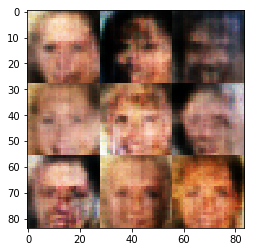

Epoch 1/1:  Discriminator Loss: 1.1717 Generator Loss: 0.8653
Epoch 1/1:  Discriminator Loss: 1.3856 Generator Loss: 1.9722
Epoch 1/1:  Discriminator Loss: 1.3513 Generator Loss: 0.6665
Epoch 1/1:  Discriminator Loss: 1.2773 Generator Loss: 0.6822
Epoch 1/1:  Discriminator Loss: 1.1067 Generator Loss: 1.1613
Epoch 1/1:  Discriminator Loss: 1.1893 Generator Loss: 1.1243
Epoch 1/1:  Discriminator Loss: 1.1929 Generator Loss: 1.1176
Epoch 1/1:  Discriminator Loss: 1.1632 Generator Loss: 0.9288
Epoch 1/1:  Discriminator Loss: 1.0953 Generator Loss: 0.9571
Epoch 1/1:  Discriminator Loss: 1.0689 Generator Loss: 0.8506


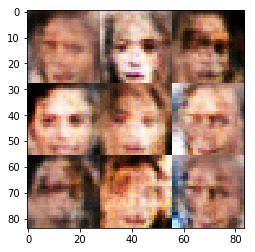

Epoch 1/1:  Discriminator Loss: 1.0495 Generator Loss: 1.2546
Epoch 1/1:  Discriminator Loss: 1.4508 Generator Loss: 2.2130
Epoch 1/1:  Discriminator Loss: 0.9940 Generator Loss: 1.1163
Epoch 1/1:  Discriminator Loss: 1.0755 Generator Loss: 0.9458
Epoch 1/1:  Discriminator Loss: 1.1230 Generator Loss: 1.0487
Epoch 1/1:  Discriminator Loss: 0.9536 Generator Loss: 1.0589
Epoch 1/1:  Discriminator Loss: 1.0129 Generator Loss: 1.3202
Epoch 1/1:  Discriminator Loss: 1.0649 Generator Loss: 1.3028
Epoch 1/1:  Discriminator Loss: 0.9925 Generator Loss: 0.9953
Epoch 1/1:  Discriminator Loss: 1.1732 Generator Loss: 0.8816


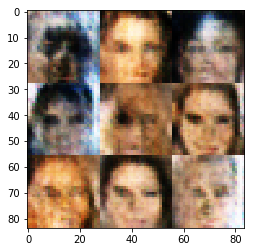

Epoch 1/1:  Discriminator Loss: 0.9847 Generator Loss: 1.5137
Epoch 1/1:  Discriminator Loss: 1.1856 Generator Loss: 1.0322
Epoch 1/1:  Discriminator Loss: 1.5720 Generator Loss: 0.4400
Epoch 1/1:  Discriminator Loss: 1.0180 Generator Loss: 1.0184
Epoch 1/1:  Discriminator Loss: 1.1704 Generator Loss: 0.9014
Epoch 1/1:  Discriminator Loss: 1.1067 Generator Loss: 0.8282
Epoch 1/1:  Discriminator Loss: 1.1165 Generator Loss: 0.8070
Epoch 1/1:  Discriminator Loss: 1.2925 Generator Loss: 0.6898
Epoch 1/1:  Discriminator Loss: 1.1619 Generator Loss: 2.2416
Epoch 1/1:  Discriminator Loss: 1.7776 Generator Loss: 2.3559


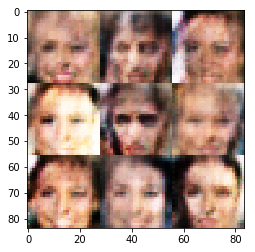

Epoch 1/1:  Discriminator Loss: 1.3638 Generator Loss: 2.1348
Epoch 1/1:  Discriminator Loss: 1.1527 Generator Loss: 0.7734
Epoch 1/1:  Discriminator Loss: 1.0860 Generator Loss: 1.9953
Epoch 1/1:  Discriminator Loss: 1.1070 Generator Loss: 1.3280
Epoch 1/1:  Discriminator Loss: 1.0788 Generator Loss: 1.8916
Epoch 1/1:  Discriminator Loss: 1.0128 Generator Loss: 1.6965
Epoch 1/1:  Discriminator Loss: 1.2526 Generator Loss: 1.4887
Epoch 1/1:  Discriminator Loss: 1.1560 Generator Loss: 0.8901
Epoch 1/1:  Discriminator Loss: 1.2423 Generator Loss: 0.8291
Epoch 1/1:  Discriminator Loss: 1.1594 Generator Loss: 1.1230


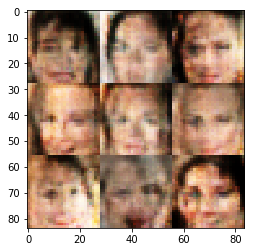

Epoch 1/1:  Discriminator Loss: 1.0516 Generator Loss: 1.4435
Epoch 1/1:  Discriminator Loss: 1.0181 Generator Loss: 1.2079
Epoch 1/1:  Discriminator Loss: 1.1654 Generator Loss: 0.9604
Epoch 1/1:  Discriminator Loss: 0.9955 Generator Loss: 1.2673
Epoch 1/1:  Discriminator Loss: 0.9824 Generator Loss: 1.2629
Epoch 1/1:  Discriminator Loss: 1.3044 Generator Loss: 1.8045
Epoch 1/1:  Discriminator Loss: 1.4167 Generator Loss: 1.5677
Epoch 1/1:  Discriminator Loss: 1.1322 Generator Loss: 0.9722
Epoch 1/1:  Discriminator Loss: 1.1956 Generator Loss: 0.7115
Epoch 1/1:  Discriminator Loss: 1.2415 Generator Loss: 0.8002


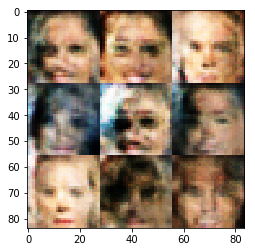

Epoch 1/1:  Discriminator Loss: 0.9196 Generator Loss: 1.8951
Epoch 1/1:  Discriminator Loss: 0.9794 Generator Loss: 1.2480
Epoch 1/1:  Discriminator Loss: 1.1713 Generator Loss: 0.8494
Epoch 1/1:  Discriminator Loss: 0.9840 Generator Loss: 1.5069
Epoch 1/1:  Discriminator Loss: 1.0269 Generator Loss: 0.9059
Epoch 1/1:  Discriminator Loss: 1.1180 Generator Loss: 0.9102
Epoch 1/1:  Discriminator Loss: 1.8841 Generator Loss: 0.3746
Epoch 1/1:  Discriminator Loss: 1.1273 Generator Loss: 1.2157
Epoch 1/1:  Discriminator Loss: 1.3325 Generator Loss: 1.0508
Epoch 1/1:  Discriminator Loss: 1.3326 Generator Loss: 0.7012


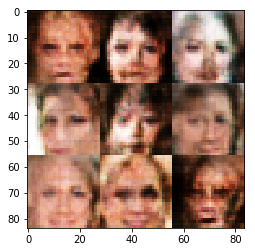

Epoch 1/1:  Discriminator Loss: 1.6104 Generator Loss: 2.5887
Epoch 1/1:  Discriminator Loss: 1.1606 Generator Loss: 0.8044
Epoch 1/1:  Discriminator Loss: 1.0096 Generator Loss: 1.2154
Epoch 1/1:  Discriminator Loss: 1.2638 Generator Loss: 1.0261
Epoch 1/1:  Discriminator Loss: 0.9492 Generator Loss: 1.3567
Epoch 1/1:  Discriminator Loss: 1.3721 Generator Loss: 0.6556
Epoch 1/1:  Discriminator Loss: 1.2164 Generator Loss: 1.1763
Epoch 1/1:  Discriminator Loss: 0.9968 Generator Loss: 1.1673
Epoch 1/1:  Discriminator Loss: 1.0240 Generator Loss: 1.6012
Epoch 1/1:  Discriminator Loss: 1.0591 Generator Loss: 1.3188


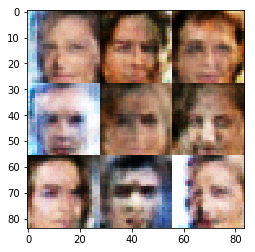

Epoch 1/1:  Discriminator Loss: 0.9391 Generator Loss: 1.1349
Epoch 1/1:  Discriminator Loss: 1.0777 Generator Loss: 1.6030
Epoch 1/1:  Discriminator Loss: 1.2424 Generator Loss: 0.7429
Epoch 1/1:  Discriminator Loss: 0.8918 Generator Loss: 1.8178
Epoch 1/1:  Discriminator Loss: 1.1224 Generator Loss: 1.4080
Epoch 1/1:  Discriminator Loss: 1.2440 Generator Loss: 2.0034
Epoch 1/1:  Discriminator Loss: 1.0907 Generator Loss: 1.6728
Epoch 1/1:  Discriminator Loss: 1.0719 Generator Loss: 0.7869
Epoch 1/1:  Discriminator Loss: 1.0563 Generator Loss: 1.0560
Epoch 1/1:  Discriminator Loss: 1.3928 Generator Loss: 2.3604


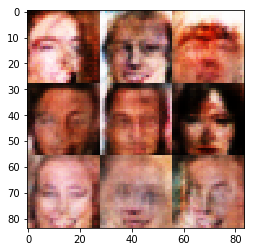

Epoch 1/1:  Discriminator Loss: 1.2157 Generator Loss: 1.3954
Epoch 1/1:  Discriminator Loss: 1.4725 Generator Loss: 0.5345
Epoch 1/1:  Discriminator Loss: 0.9086 Generator Loss: 1.7082
Epoch 1/1:  Discriminator Loss: 1.3511 Generator Loss: 1.4080
Epoch 1/1:  Discriminator Loss: 1.1200 Generator Loss: 1.0474
Epoch 1/1:  Discriminator Loss: 1.2717 Generator Loss: 0.6012
Epoch 1/1:  Discriminator Loss: 1.0866 Generator Loss: 1.1522
Epoch 1/1:  Discriminator Loss: 1.1449 Generator Loss: 1.9552
Epoch 1/1:  Discriminator Loss: 1.5032 Generator Loss: 0.5009
Epoch 1/1:  Discriminator Loss: 1.2769 Generator Loss: 1.1145


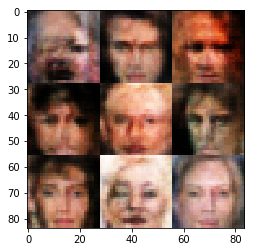

Epoch 1/1:  Discriminator Loss: 1.1413 Generator Loss: 1.3587
Epoch 1/1:  Discriminator Loss: 0.9437 Generator Loss: 1.8320
Epoch 1/1:  Discriminator Loss: 1.1498 Generator Loss: 0.7828
Epoch 1/1:  Discriminator Loss: 1.0692 Generator Loss: 0.8934
Epoch 1/1:  Discriminator Loss: 1.0902 Generator Loss: 1.1988
Epoch 1/1:  Discriminator Loss: 1.0831 Generator Loss: 1.5311
Epoch 1/1:  Discriminator Loss: 1.0890 Generator Loss: 0.9558
Epoch 1/1:  Discriminator Loss: 1.0819 Generator Loss: 1.0994
Epoch 1/1:  Discriminator Loss: 1.9939 Generator Loss: 0.2717
Epoch 1/1:  Discriminator Loss: 1.1033 Generator Loss: 1.0113


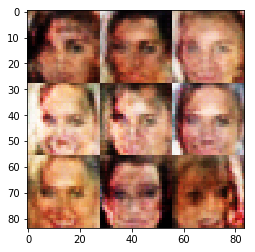

Epoch 1/1:  Discriminator Loss: 1.3347 Generator Loss: 0.7959
Epoch 1/1:  Discriminator Loss: 1.0861 Generator Loss: 1.1158
Epoch 1/1:  Discriminator Loss: 1.2787 Generator Loss: 0.6195
Epoch 1/1:  Discriminator Loss: 1.4882 Generator Loss: 2.5794
Epoch 1/1:  Discriminator Loss: 1.0649 Generator Loss: 1.2220
Epoch 1/1:  Discriminator Loss: 1.1099 Generator Loss: 1.2990
Epoch 1/1:  Discriminator Loss: 1.0407 Generator Loss: 1.3474
Epoch 1/1:  Discriminator Loss: 1.6585 Generator Loss: 0.4082
Epoch 1/1:  Discriminator Loss: 1.2522 Generator Loss: 0.7428
Epoch 1/1:  Discriminator Loss: 1.2099 Generator Loss: 0.8368


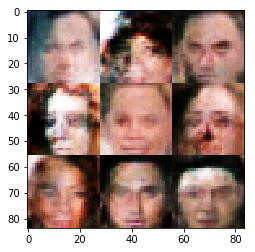

Epoch 1/1:  Discriminator Loss: 1.1183 Generator Loss: 0.8124
Epoch 1/1:  Discriminator Loss: 1.0820 Generator Loss: 1.4260
Epoch 1/1:  Discriminator Loss: 1.3760 Generator Loss: 1.5875
Epoch 1/1:  Discriminator Loss: 1.1982 Generator Loss: 1.2206
Epoch 1/1:  Discriminator Loss: 1.1492 Generator Loss: 1.2216
Epoch 1/1:  Discriminator Loss: 1.1398 Generator Loss: 1.4464
Epoch 1/1:  Discriminator Loss: 0.9819 Generator Loss: 1.4589
Epoch 1/1:  Discriminator Loss: 1.0290 Generator Loss: 1.4860
Epoch 1/1:  Discriminator Loss: 1.1764 Generator Loss: 2.0151
Epoch 1/1:  Discriminator Loss: 1.1011 Generator Loss: 0.8443


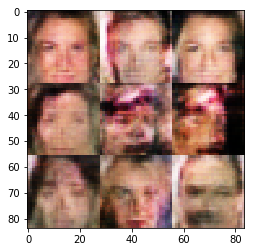

Epoch 1/1:  Discriminator Loss: 1.2023 Generator Loss: 0.7729
Epoch 1/1:  Discriminator Loss: 1.3378 Generator Loss: 0.6051
Epoch 1/1:  Discriminator Loss: 1.0301 Generator Loss: 1.9854
Epoch 1/1:  Discriminator Loss: 1.2824 Generator Loss: 1.8375
Epoch 1/1:  Discriminator Loss: 1.0716 Generator Loss: 0.9834
Epoch 1/1:  Discriminator Loss: 1.0781 Generator Loss: 0.8210
Epoch 1/1:  Discriminator Loss: 1.1711 Generator Loss: 0.8277
Epoch 1/1:  Discriminator Loss: 1.3923 Generator Loss: 0.6425
Epoch 1/1:  Discriminator Loss: 1.2630 Generator Loss: 0.7608
Epoch 1/1:  Discriminator Loss: 1.0285 Generator Loss: 1.0867


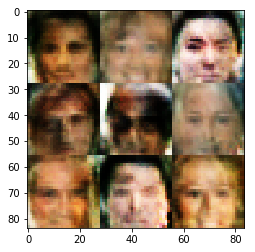

Epoch 1/1:  Discriminator Loss: 0.9789 Generator Loss: 0.9098
Epoch 1/1:  Discriminator Loss: 1.0947 Generator Loss: 0.9588
Epoch 1/1:  Discriminator Loss: 1.3160 Generator Loss: 0.6040
Epoch 1/1:  Discriminator Loss: 1.2997 Generator Loss: 1.7101
Epoch 1/1:  Discriminator Loss: 0.9940 Generator Loss: 1.1300
Epoch 1/1:  Discriminator Loss: 1.6028 Generator Loss: 0.4093
Epoch 1/1:  Discriminator Loss: 1.3697 Generator Loss: 0.5865
Epoch 1/1:  Discriminator Loss: 1.1739 Generator Loss: 0.7927
Epoch 1/1:  Discriminator Loss: 1.2467 Generator Loss: 0.6405
Epoch 1/1:  Discriminator Loss: 1.1000 Generator Loss: 0.8625


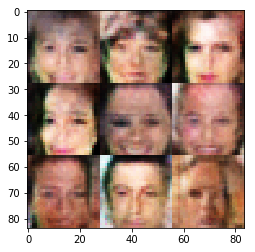

Epoch 1/1:  Discriminator Loss: 1.0818 Generator Loss: 0.9884
Epoch 1/1:  Discriminator Loss: 1.4664 Generator Loss: 0.5397
Epoch 1/1:  Discriminator Loss: 1.0731 Generator Loss: 0.8841
Epoch 1/1:  Discriminator Loss: 1.0310 Generator Loss: 1.1671
Epoch 1/1:  Discriminator Loss: 1.1906 Generator Loss: 0.8195
Epoch 1/1:  Discriminator Loss: 1.0667 Generator Loss: 1.3502
Epoch 1/1:  Discriminator Loss: 1.1736 Generator Loss: 0.8607
Epoch 1/1:  Discriminator Loss: 0.9865 Generator Loss: 1.1827
Epoch 1/1:  Discriminator Loss: 1.2021 Generator Loss: 1.3112
Epoch 1/1:  Discriminator Loss: 1.1555 Generator Loss: 0.8980


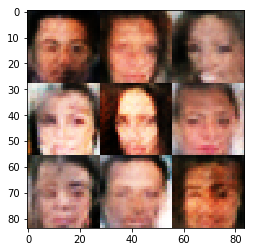

Epoch 1/1:  Discriminator Loss: 1.1395 Generator Loss: 0.7434
Epoch 1/1:  Discriminator Loss: 1.1220 Generator Loss: 1.3418
Epoch 1/1:  Discriminator Loss: 1.0441 Generator Loss: 1.4958
Epoch 1/1:  Discriminator Loss: 1.0989 Generator Loss: 0.8114
Epoch 1/1:  Discriminator Loss: 1.1070 Generator Loss: 1.3135
Epoch 1/1:  Discriminator Loss: 1.0288 Generator Loss: 1.4191
Epoch 1/1:  Discriminator Loss: 0.9308 Generator Loss: 1.3556
Epoch 1/1:  Discriminator Loss: 1.0319 Generator Loss: 0.9420
Epoch 1/1:  Discriminator Loss: 0.9296 Generator Loss: 1.2963
Epoch 1/1:  Discriminator Loss: 1.1552 Generator Loss: 1.7123


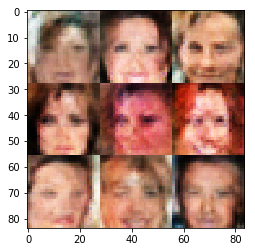

Epoch 1/1:  Discriminator Loss: 1.2605 Generator Loss: 0.6486
Epoch 1/1:  Discriminator Loss: 1.1645 Generator Loss: 1.3780
Epoch 1/1:  Discriminator Loss: 1.1808 Generator Loss: 0.7724
Epoch 1/1:  Discriminator Loss: 1.1798 Generator Loss: 0.7269
Epoch 1/1:  Discriminator Loss: 1.3124 Generator Loss: 1.0006
Epoch 1/1:  Discriminator Loss: 1.1523 Generator Loss: 1.0244
Epoch 1/1:  Discriminator Loss: 1.2197 Generator Loss: 1.1621
Epoch 1/1:  Discriminator Loss: 1.0675 Generator Loss: 0.8945
Epoch 1/1:  Discriminator Loss: 1.1674 Generator Loss: 0.8660
Epoch 1/1:  Discriminator Loss: 1.1043 Generator Loss: 0.8977


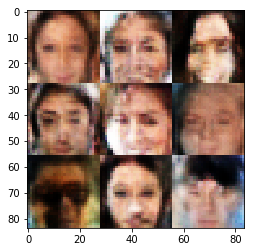

Epoch 1/1:  Discriminator Loss: 1.1529 Generator Loss: 0.9817
Epoch 1/1:  Discriminator Loss: 1.1619 Generator Loss: 0.8295
Epoch 1/1:  Discriminator Loss: 1.0597 Generator Loss: 0.9032
Epoch 1/1:  Discriminator Loss: 1.0577 Generator Loss: 0.9391
Epoch 1/1:  Discriminator Loss: 1.0637 Generator Loss: 0.9080
Epoch 1/1:  Discriminator Loss: 1.1074 Generator Loss: 0.8164
Epoch 1/1:  Discriminator Loss: 1.0338 Generator Loss: 0.9020


In [73]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.